# Finite Impulse Response Filter
A sensor records not only the wanted signal but also a lot of noise.
The simplest way to recude this noise is a bandpass-filter.
For applying a bandpass for noise reduction, you need to know the frequency range of the wanted signal of your sensor.

In the following, the wanted signal $x(n)$ is a sweep ranging from low frequencies up to the highest frequencies. This signal should be a very simple model of human voice.

y(n) is the sensorsignal, which corresponds to the wanted signal plus additive gaussian noise.

In [21]:
import numpy as np
import matplotlib.pyplot as plt

r = 48000
f = np.arange(r)/r * 3000 + 100
t = np.arange(r)/r
x = np.sin(2*np.pi*f*t)
y = x + 0.2*np.random.randn(x.shape[0])
SNR = 10*np.log10(np.sum(x**2) / np.sum((x-y)**2))
print('SNR of the sensor: ', SNR, ' dB')

SNR of the sensor:  11.013556588053898  dB


## z-Transform
The corresponding spectrum can be evaluated by the z-transform

$X(z)=\sum_{n=-\infty}^\infty x(n)\cdot z^{-n}$ with

$z=e^{j2\pi fT}$ and $T=\frac{1}{r}$:

$X(f)=\sum_{n=-\infty}^\infty x(n)\cdot e^{-j2\pi f n/r}$

The z-transform can only be evaluated numerically, if the input signal $x(n)$ has finite length.

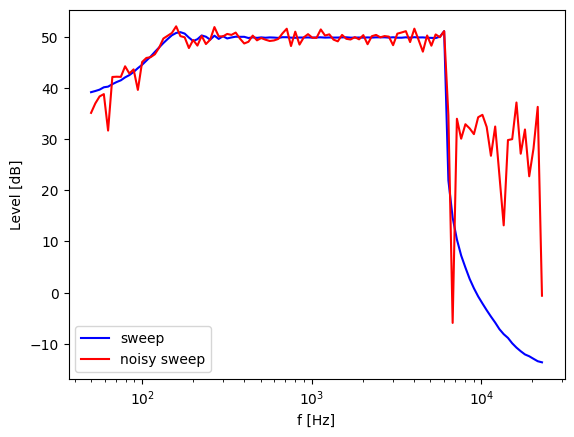

In [22]:
def EvaluateSpectrum(x, r):
    LowestFrequency = 50
    HighestFrequency = r/2
    NumberOfFrequencyBins = 12*np.log2(HighestFrequency / LowestFrequency)
    f = 50 * (2**(np.arange(NumberOfFrequencyBins) / 12))
    X = np.zeros(f.shape, dtype = complex)
    for n in range(x.shape[0]):
        X += x[n] * np.exp(-1j*2*np.pi*f*n/r)
    X = 20*np.log10(np.abs(X))
    return X, f

X, f = EvaluateSpectrum(x, r)
Y, f = EvaluateSpectrum(y, r)
plt.semilogx(f, X, 'b', label="sweep")
plt.semilogx(f, Y, 'r', label="noisy sweep")
plt.xlabel('f [Hz]')
plt.ylabel('Level [dB]')
plt.legend(loc="lower left")
plt.show()

## FIR Lowpass
A simple lowpass filter with cutoff frequency $f_c$ is defined by:

$h_\text{lowpass}(n)=\frac{\sin\left(2\pi f_c n/r\right)}{2\pi f_c n/r}\cdot w(n)$

with the Hann window

$w(n)=\frac{1}{2}\left(1+\cos\left(2\pi n / N \right)\right)$.

Both filters are defined in the range $-\frac{N}{2}< n < \frac{N}{2}$.

## FIR Bandpass
Each lowpass filter with cutoff frequency $f_c$ can be transformed into a bandpass filter with center frequency $f_m$ and bandwidth $f_\Delta=2\cdot f_c$:

$h_\text{bandpass}(n)=h_\text{lowpass}(n) \cdot \cos\left(2\pi f_m n/r\right)$

## FIR Highpass
Each lowpass filter with cutoff frequency $f_{c, LP}$ can be transformed into a highpass filter with cutoff frequency $f_{c, HP} = \frac{r}{2} - f_{c, LP}$:

$h_\text{highpass}(n)=h_\text{lowpass}(n) \cdot \left(-1\right)^n$

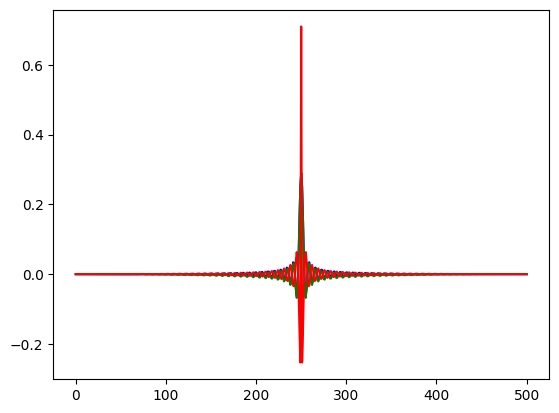

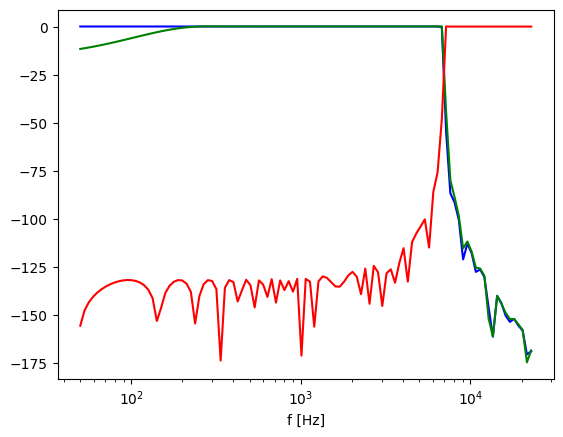

In [23]:
def LowpassFilter(fc, r):
    assert fc < r/2, 'violation of sampling theorem'
    LengthOfFilterInSamples = 501
    n = np.arange(LengthOfFilterInSamples) - np.floor(LengthOfFilterInSamples / 2)
    t = n / r
    h_LP = np.sinc(2 * fc * t)
    w = 0.5 * (1 + np.cos(2 * np.pi * n / LengthOfFilterInSamples)) # Hann-Window
    h = w * h_LP
    h /= np.sum(h**2)
    return h

def ApplyFCenter(h, f_center, r):
    t = np.arange(h.shape[0]) / r
    t -= np.mean(t)
    return h * np.cos(2*np.pi*f_center*t)

def BandpassFilter(f_low, f_high, r):
    assert f_high > f_low, 'lower frequency must be lower than higher frequency'
    assert f_high < r/2, 'violation of sampling theorem'
    h_LP = LowpassFilter((f_high - f_low)/2, r)
    f_center = (f_low + f_high) / 2
    return 2*ApplyFCenter(h_LP, f_center, r)

def HighpassFilter(fc, r):
    assert fc < r/2, 'violation of sampling theorem'
    h_LP = LowpassFilter(r/2 - fc, r)
    f_center = r/2
    return ApplyFCenter(h_LP, f_center, r)

h_LP = LowpassFilter(6900, r)
h_BP = BandpassFilter(100, 7000, r)
h_HP = HighpassFilter(7000, r)
plt.plot(h_LP, 'b')
plt.plot(h_BP, 'g')
plt.plot(h_HP, 'r')
plt.show()

H_LP, f = EvaluateSpectrum(h_LP, r)
H_BP, f = EvaluateSpectrum(h_BP, r)
H_HP, f = EvaluateSpectrum(h_HP, r)
plt.semilogx(f, H_LP, 'b')
plt.semilogx(f, H_BP, 'g')
plt.semilogx(f, H_HP, 'r')
plt.xlabel('f [Hz]')
plt.show()

## Denoising by bandpass-filtering

In the following, a bandpass is defined, which let  the most significant parts of voice (wideband voice) pass. This bandpass introduces a delay $T$ and a change $a$ regarding the amplitude:

$z(n)=a\cdot y(n-T)$

The delay of a symmetric filter is half of the length of the filter: $T=\frac{N}{2}$ .

The best estimate for the change in amplitude is evaluated by minimizing the squared error (and thus maximizing the SNR):

minimize regarding to the parameter $a$: $\sum_n \left(a\cdot y(n-T) - z(n)\right)^2$

The minimum is found for:

$a=\frac{\sum_n y\left(n-T\right)\cdot z(n)}{\sum_n y(n-T)^2}$

delay due to filtering in samples: T =  250
gain due to filtering =  0.9567446009843771
SNR before the bandpass:  11.013556588053898  dB
SNR after the bandpass:  15.435408506806208  dB


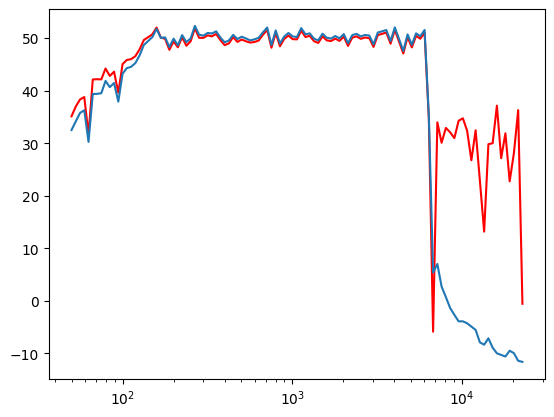

In [24]:
LowerCutoffFrequencyInHertz = 50
UpperCutoffFrequencyInHertz = 7000
h_BP = BandpassFilter(LowerCutoffFrequencyInHertz, UpperCutoffFrequencyInHertz, r)
z = np.convolve(y, h_BP)
T = h_BP.shape[0] // 2
print('delay due to filtering in samples: T = ', T)
z = z[T:x.shape[0]+T]
a = np.sum(y*z) / np.sum(y**2)
print('gain due to filtering = ', a)
z /= a
SNR = 10*np.log10(np.sum(x**2) / np.sum((x - y)**2))
print('SNR before the bandpass: ', SNR, ' dB')
SNR = 10*np.log10(np.sum(x**2) / np.sum((x - z)**2))
print('SNR after the bandpass: ', SNR, ' dB')


Z, f = EvaluateSpectrum(z, r)
plt.semilogx(f, Y, 'r') # noisy signal
plt.semilogx(f, Z) # denoised signal after the bandpass
plt.show()

## Computational complexity

The convolution is a relatively hard algorithm for evaluation. It needs in time domain two for loops as shown in the code below.

Faster evaluation is possible by the fft, which is not shown here.

In [25]:
import time

y = np.random.randn(10000)

t0 = time.time()
z1 = np.convolve(y, h_BP)
t1 = time.time()
z2 = np.zeros(z1.shape)
for n in range(z1.shape[0]):
    for k in range(h_BP.shape[0]):
        if (n-k >= 0) and (n-k < y.shape[0]):
            z2[n] += h_BP[k] * y[n-k]
t2 = time.time()

print('np.convolve needs ', t1 - t0, ' seconds')
print('two for-loops need ', t2 - t1, ' seconds')

RMSError = np.sqrt(np.mean((z1 - z2)**2))
assert RMSError < 1e-10, 'error in evaluation'

np.convolve needs  0.001149892807006836  seconds
two for-loops need  6.122938871383667  seconds


## Frequency range of human voice

Human voice can typically be recorded in three different modes:

Narrowband corresponds to a frequency range of $300 \text{ Hz}<f<3400\text{ Hz}$.

Wideband corresponds to a frequency range of $50 \text{ Hz}<f<7000\text{ Hz}$.

Fullband corresponds to a frequency range of $20 \text{ Hz}<f<20000\text{ Hz}$.

Listen to the output and rate the signals Narrowband, Wideband and Fullband regarding their quality.

In [26]:
import sys
sys.path.insert(0, '../Python')
import WaveInterface

x, r, w = WaveInterface.ReadWave('../Audio/P501_D_EN_fm_SWB_48k.wav')
print('sampling rate: r=', r)

def ApplyBandpass(x, r, fc1, fc2):
    h_BP = BandpassFilter(fc1, fc2, r)
    y = np.convolve(x, h_BP)
    y /= np.amax(np.abs(y))
    return y

y_NB = ApplyBandpass(x, r, 300, 3400)
WaveInterface.WriteWave(y_NB, r, w, 'Narrowband.wav')
y_WB = ApplyBandpass(x, r, 50, 7000)
WaveInterface.WriteWave(y_WB, r, w, 'Wideband.wav')
y_FB = ApplyBandpass(x, r, 20, 20000)
WaveInterface.WriteWave(y_FB, r, w, 'Fullband.wav')

sampling rate: r= 48000


## Programming exercise:

The cutoff frequency $f_c$ of a lowpass $X(f)$ is defined by:

$\frac{\left|H\left(f_c\right)\right|}{\left|H\right|_\text{max}}=\frac{1}{\sqrt{2}}$ (1)

In logarithmic scale this corresponds to:

$20\log_{10}\frac{1}{\sqrt{2}}=-3.01$ dB

A bandpass has two cutoff frequencies, which marks the passband. For simplicity, the cutoff frequencies of a bandpass are defined as follows:

The lower cutoff frequency is the lowest frequency for which condition (1) is true.

The higher cutoff frequency is the highest frequency for which condition (1) is true.

Write a procedure, which evaluates the cutoff frequencies for a time discrete bandpass given in time domain. For this, use the z-transform in order to evaluate the cutoff frequencies with an accuracy of $25$ Hz.

In [29]:
def EvaluateZTransform(h, f, r):
    H = np.zeros(f.shape, dtype = complex)
    ### solution begins
    for n in range(h.shape[0]):
        H += h[n] * np.exp(-1j*2*np.pi*f*n/r)
    ### solution ends
    return 20*np.log10(np.abs(H) + 1e-20)

def EvaluateCutoffFrequencies(h_Bandpass, r):
    ### solution begins
    f = np.arange(r//2)
    X = EvaluateZTransform(h_Bandpass, f, r)
    X_max = np.amax(X)
    PositionOfLowerCutoffFrequency = 0
    while (X[PositionOfLowerCutoffFrequency] + 3.01) < X_max:
        PositionOfLowerCutoffFrequency += 1
    fc1 = f[PositionOfLowerCutoffFrequency]
    PositionOfHigherCutoffFrequency = X.shape[0] - 1
    while (X[PositionOfHigherCutoffFrequency] + 3.01) < X_max:
        PositionOfHigherCutoffFrequency -= 1
    fc2 = f[PositionOfHigherCutoffFrequency]
    ### solution ends
    return fc1, fc2

import unittest

class TestProgrammingExercise(unittest.TestCase):

    def test_EvaluateZTransform(self):
        r = 16000
        h = np.array([1, -2, 1])
        f = np.arange(1000) / 1000 * r / 2
        H = EvaluateZTransform(h, f, r)
        self.assertEqual(H.shape, f.shape)
        for n in range(1, f.shape[0]):
            self.assertGreater(H[n], H[n-1])
    
    def test_RandomBandpasses(self):
        r = 16000
        for n in range(10):
            fc1 = np.random.rand(1) * r/8 + r/8
            fc2 = r/2 - (np.random.rand(1) * r/8 + r/8)
            h_Bandpass = BandpassFilter(fc1, fc2, r)
            fc1_est, fc2_est = EvaluateCutoffFrequencies(h_Bandpass, r)
            self.assertAlmostEqual(fc1_est, fc1, delta = 20.0)
            self.assertAlmostEqual(fc2_est, fc2, delta = 20.0)
    
# https://stackoverflow.com/questions/40172281/unit-tests-for-functions-in-a-jupyter-notebook
unittest.main(argv=[''], verbosity=2, exit=False)

test_EvaluateZTransform (__main__.TestProgrammingExercise.test_EvaluateZTransform) ... ok
test_RandomBandpasses (__main__.TestProgrammingExercise.test_RandomBandpasses) ... ok

----------------------------------------------------------------------
Ran 2 tests in 4.483s

OK


## Exam preparation

1) Evaluate the z-transform of a filter $h(n)=[1, 2, 1]$. Is this filter a lowpass, a bandpass or a highpass (for simpler evaluation: $r=1$ is assumed)?

2) Convert the filter $h(n)=[1, 2, 1]$ into a highpass.

3) Evaluate the convolution of $x(n) = [0, 1, 2]$ with $h(n)=[1, 2, 1]$.

4) Evaluate the samples of a lowpass filter of length $N=5$ for a sampling rate of $r=1000$ Hz and a cutoff frequency of $f_c = 250$ Hz.

5) How many multiplications and additions are necessary to evaluate a single output sample of a filter with length $N=501$ samples.

6) Show that $a=\frac{\sum_n y\left(n-T\right)\cdot z(n)}{\sum_n y(n-T)^2}$ minimizes $\sum_n \left(a\cdot y(n-T) - z(n)\right)^2$ .

7) White background noise has roughly a constant power density spectrum $\left|R(f)\right|^2\approx \text{const}$. Evaluate the increase in SNR by using an ideal bandpass with cut off frequencies $f_{c1}=100$ Hz and $f_{c2}=7000$ Hz, assuming, that the human voice can pass this filter without any decrease in quality. The sampling rate is assumed to be $r=48$ kHz.

8) A lowpass is given: $h(n)=[a,1,a]$ with $a$ being real valued. For which $a$, the following condition is true? $\left|H(f)\right| > 0$